In [10]:
from PIL import Image, ImageDraw, ImageFont
import random
from random import randint
import pandas as pd
import numpy as np
import h5py
import datetime as dt
import matplotlib.pyplot as plt

In [11]:
def add_feature(img, features, target_type):
    '''
    Routine to add objects (X or O) to an empty image with white background.
    
    Arguments:
    ----------
    img : PIL image object with white background.
    features: numpy matrix with feature information.
              features include green O, red O, green X, red X.
    target_type: int value to represent either red O or red X as target.
    
    Returns:
    --------
    colour_red: numpy 2D array to represent presence of colour red (1: present, 0: absent)
    colour_green: numpy 2D array to represent presence of colour green (1: present, 0: absent)
    shape_o: numpy 2D array to represent presence of shape O (1: present, 0: absent)
    shape_x: numpy 2D array to represent presence of shape X (1: present, 0: absent)
    '''
    # Initialise output 2D arrays
    colour_red = np.zeros((7,7))
    colour_green = np.zeros((7,7))
    shape_o = np.zeros((7,7))
    shape_x = np.zeros((7,7))
    # Intital horizontal and vertical posiiton to start drawing objects.
    hor = 2
    ver = 2
    
    # When target is red O.
    if target_type == 1:
        for row in range(7):
            for col in range(7):
                if features[row][col] == 1:
                    img.text((hor, ver), "X", font=fnt, fill=(255,0,0))
                    colour_red[row][col] = 1
                    shape_x[row][col] = 1
                    
                elif features[row][col] == 2:
                    img.text((hor, ver), "O", font=fnt, fill=(255,0,0))
                    colour_red[row][col] = 1
                    shape_o[row][col] = 1
                    
                else:
                    img.text((hor, ver), "O", font=fnt, fill=(0,255,0))
                    colour_green[row][col] = 1
                    shape_o[row][col] = 1
                hor = hor +  9
            ver = ver +  9
            hor = 2
    else: # When target is red X.
        for row in range(7):
            for col in range(7):
                if features[row][col] == 1:
                    img.text((hor, ver), "O", font=fnt, fill=(255,0,0))
                    colour_red[row][col] = 1
                    shape_o[row][col] = 1
                    
                elif features[row][col] == 2:
                    img.text((hor, ver), "X", font=fnt, fill=(255,0,0))
                    colour_red[row][col] = 1
                    shape_x[row][col] = 1
                    
                else:
                    img.text((hor, ver), "X", font=fnt, fill=(0,255,0))
                    colour_green[row][col] = 1
                    shape_x[row][col] = 1
                # Add blank space of 9px between objects horizontally.
                hor = hor +  9
            # Add blank space of 9px between objects vertically.
            ver = ver +  9
            # horizontal shift because first 2px of row is empty.
            hor = 2
    return colour_red, colour_green, shape_o, shape_x

In [12]:
'''
Routine to create a PIL image and save it in a h5py file. 
'''
# font style file.
fnt = ImageFont.truetype('pixel.TTF', 8)
# Total number of objects in the image.
N_DR_ELEMENTS = 49

image_id = 0
# ratios of different object in the image.
ratios = [3,6,9,12,15,18,21,24,27,30,33,36,39,42,45]

# Output feature label as a pandas table.
df = pd.DataFrame(columns=['image_id', 'colour_red', 'colour_green', 'shape_o', 'shape_x'])
sample_list = list(range(0, N_DR_ELEMENTS, 1))
start = dt.datetime.now()

with h5py.File('dr_data_all.h5', 'w') as hf: 
    image_array = []
    image_colour_red = []
    image_colour_green = []
    image_shape_o = []
    image_shape_x = []
    image_ratio = []
    image_target_status = []
    
    for ratio in ratios:
        print(ratio)
        #Generate 2000 random displays for each ratio.
        for i in range(2000):
            target_present = 0
            target_type = 1
            features = np.zeros((7,7))
            random_list = np.random.choice(sample_list, ratio, replace=False)
            features.ravel()[random_list] = 1
            if random.random() > 0.5:
                target_present = 1
                loc = randint(0,N_DR_ELEMENTS-1)
                features.ravel()[loc] = 2
            if random.random() > 0.5:
                target_type = 2

            img = Image.new('RGB', (64, 64), color = 'white')
            d = ImageDraw.Draw(img)
            colour_red, colour_green, shape_o, shape_x = add_feature(d, features, target_type)
            # Images
            img = np.array(img)
            image_array.append(img)
            image_colour_red.append(colour_red)
            image_colour_green.append(colour_green)
            image_shape_o.append(shape_o)
            image_shape_x.append(shape_x)
            image_ratio.append(ratio)
            image_target_status.append(target_present)
    
    image_array = np.array(image_array)
    image_colour_red = np.array(image_colour_red)
    image_colour_green = np.array(image_colour_green)
    image_shape_o = np.array(image_shape_o)
    image_shape_x = np.array(image_shape_x)
    image_ratio = np.array(image_ratio)
    image_target_status = np.array(image_target_status)
    
    #Image dataset.
    Xset = hf.create_dataset(
        name='Images',
        data=image_array,
        shape=image_array.shape,
        compression="gzip",
        compression_opts=6) 
    
    #Label-1: colour_red
    y_a_set = hf.create_dataset(
        name='col_red_loc',
        data=image_colour_red,
        shape=image_colour_red.shape,
        compression="gzip",
        compression_opts=6)
    #Label-2: colour_green
    y_b_set = hf.create_dataset(
        name='col_green_loc',
        data=image_colour_green,
        shape=image_colour_green.shape,
        compression="gzip",
        compression_opts=6)
    #Label-3: shape_o
    y_c_set = hf.create_dataset(
        name='shape_o_loc',
        data=image_shape_o,
        shape=image_shape_o.shape,
        compression="gzip",
        compression_opts=6)
    #Label-4: shape_x
    y_d_set = hf.create_dataset(
        name='shape_x_loc',
        data=image_shape_x,
        shape=image_shape_x.shape,
        compression="gzip",
        compression_opts=6)
    #Label-5: ratio
    y_e_set = hf.create_dataset(
        name='ratio',
        data=image_ratio,
        shape=image_ratio.shape,
        compression="gzip",
        compression_opts=6)
    #Label-6: target_status
    y_f_set = hf.create_dataset(
        name='target_status',
        data=image_target_status,
        shape=image_target_status.shape,
        compression="gzip",
        compression_opts=6)  

end=dt.datetime.now()
print("\r", i, ": ", (end-start).seconds, "seconds", end="")

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
 1999 :  33 seconds

(30000, 64, 64, 3)
1


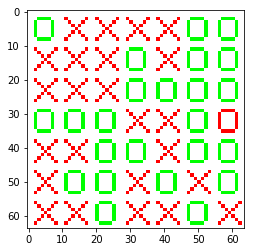

In [14]:
with h5py.File('dr_data_all.h5', 'r') as hf:
    print(hf["Images"].shape)
    plt.imshow(hf["Images"][15003])
    print(hf["target_status"][15003])